Epoch 1/10
73/73 [==============================] - 10s 71ms/step - loss: 0.0256 - val_loss: 0.0012
Epoch 2/10
73/73 [==============================] - 4s 53ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 3/10
73/73 [==============================] - 4s 52ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 4/10
73/73 [==============================] - 4s 53ms/step - loss: 0.0045 - val_loss: 8.7516e-04
Epoch 5/10
73/73 [==============================] - 4s 53ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 6/10
73/73 [==============================] - 4s 52ms/step - loss: 0.0041 - val_loss: 8.8650e-04
Epoch 7/10
73/73 [==============================] - 4s 55ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 8/10
73/73 [==============================] - 4s 53ms/step - loss: 0.0039 - val_loss: 9.0909e-04
Epoch 9/10
73/73 [==============================] - 5s 64ms/step - loss: 0.0038 - val_loss: 6.9079e-04
Epoch 10/10
73/73 [==============================] - 4s 53ms/step - loss: 0.0036 - val_loss:

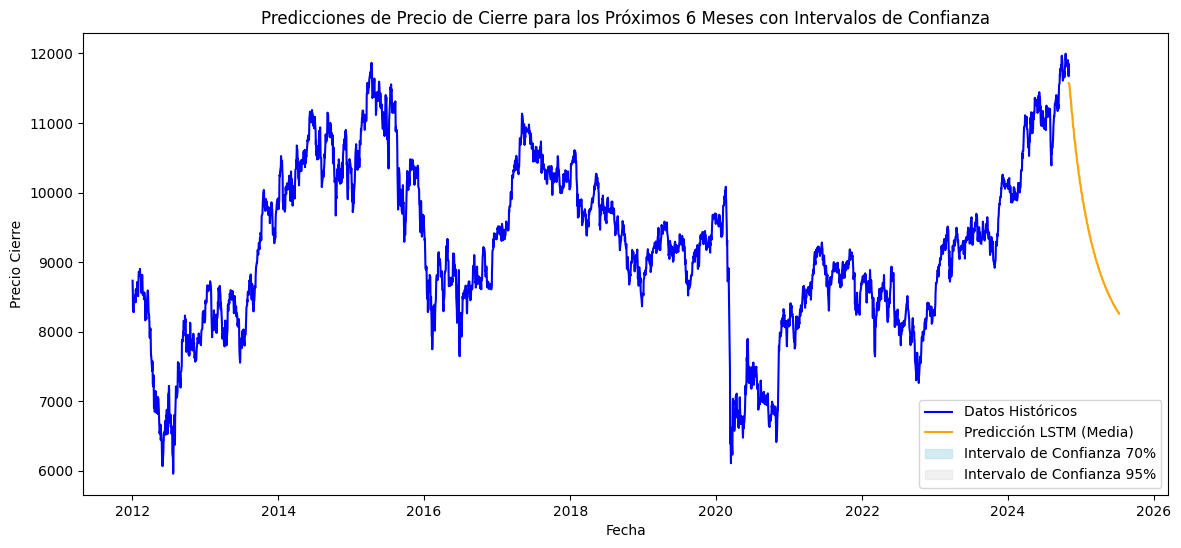

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# Cargar los datos
df = pd.read_csv("ibex_clean.csv")  # Reemplaza con la ruta a tus datos
df['Date'] = pd.to_datetime(df['Date'])  # Asegurarse de que la fecha esté en formato datetime
df.set_index('Date', inplace=True)  # Establecer la columna de fecha como índice

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
train_size = int(len(df) * 0.8)  # Usar el 80% de los datos para entrenamiento
train = df[:train_size]
test = df[train_size:]

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Preparar los datos para LSTM
time_step = 60
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - time_step:]

X_train, y_train = [], []
for i in range(time_step, len(train_data)):
    X_train.append(train_data[i - time_step:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test, y_test = [], []
for i in range(time_step, len(test_data)):
    X_test.append(test_data[i - time_step:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Predicciones con múltiples simulaciones para crear intervalos de confianza
n_simulations = 100
predictions_list = []

last_data = test_data[-time_step:].reshape(1, time_step, 1)

for _ in range(n_simulations):
    future_predictions = []
    current_data = last_data.copy()

    for _ in range(180):  # 180 días (6 meses)
        pred = model.predict(current_data, verbose=0)
        future_predictions.append(pred[0, 0])
        # Modificar la línea que causa el error
        current_data = np.append(current_data[:, 1:, :], [[[pred[0, 0]]]], axis=1)


    predictions_list.append(future_predictions)

predictions_array = np.array(predictions_list)
mean_predictions = np.mean(predictions_array, axis=0)
lower_bound_70 = np.percentile(predictions_array, 15, axis=0)
upper_bound_70 = np.percentile(predictions_array, 85, axis=0)
lower_bound_95 = np.percentile(predictions_array, 2.5, axis=0)
upper_bound_95 = np.percentile(predictions_array, 97.5, axis=0)

# Inversa de la transformación de los datos
mean_predictions = scaler.inverse_transform(mean_predictions.reshape(-1, 1))
lower_bound_70 = scaler.inverse_transform(lower_bound_70.reshape(-1, 1))
upper_bound_70 = scaler.inverse_transform(upper_bound_70.reshape(-1, 1))
lower_bound_95 = scaler.inverse_transform(lower_bound_95.reshape(-1, 1))
upper_bound_95 = scaler.inverse_transform(upper_bound_95.reshape(-1, 1))

# Crear las fechas para las predicciones futuras
future_dates = pd.date_range(start=df.index[-1], periods=180, freq='B')

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Close'], label='Datos Históricos', color='blue')
plt.plot(future_dates, mean_predictions, label='Predicción LSTM (Media)', color='orange')
plt.fill_between(future_dates, lower_bound_70.flatten(), upper_bound_70.flatten(), color='lightblue', alpha=0.5, label='Intervalo de Confianza 70%')
plt.fill_between(future_dates, lower_bound_95.flatten(), upper_bound_95.flatten(), color='lightgray', alpha=0.3, label='Intervalo de Confianza 95%')
plt.xlabel('Fecha')
plt.ylabel('Precio Cierre')
plt.title('Predicciones de Precio de Cierre para los Próximos 6 Meses con Intervalos de Confianza')
plt.legend()
plt.show()
